## Ejemplos de Redes Neuronales

Partiendo del modelo descrito en la Introducción, se puede pasar a ilustrar ejemplos con los modelos desarrollados. Como ya se explicó previamente, en numerosos lugares en el cerebro dos células interactúan, una inhibitoria y la otra excitatoria, en tal forma que una dispara una rápida ráfaga de potenciales de acción seguido por  un pulso bajo disparado por la otra. Por tanto, dos escalas de tiempo están envueltas. Los modelos que describimos a continuación reproducen dichos fenómenos.

### Circuito Thalamocortical

Muchas señalas de entrada al cerebro son procesados en el thalamus, el cual ordena las señales para su posterior procesamiento en otras estructuras cerebrales como son la corteza entorhinal en el hippocampus (Una descripción más detallada de este sistema neuronal se puede encontrar [aquí](http://www.scholarpedia.org/article/Models_of_thalamocortical_system)). Ésto envuelve un circuito entre células excitatorias e inhibitorias en una estructura paralela llamada el complejo reticular. Las células thalamicas disparan repidamente, y el complejo reticular dispara lentamente. La red para este sistema se presenta en el siguiente diagrama.

$$\sigma\rightarrow^{+}TH\mbox{  }^{-}\leftrightarrow^{+}RC\rightarrow^{+}NC$$

Ahora bien, para modelar el flujo de estímulos en la dirección $\sigma\rightarrow^{+}TH\rightarrow^{+}RC\rightarrow^{+}NC$ podemos simularlo con las siguientes expresiones:

$$\dot{x}=5.0(1+\sigma+\cos x-\cos y)\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(A)$$

$$\dot{y}=0.04(1+\cos y+10\cos x)\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(B)$$



Necesitaremos algunas paqueterias:

In [39]:
using TaylorSeries

In [40]:
println(VERSION)

using Compat

0.

In [41]:
using PyPlot

Lo siguiente será resolver las ecuaciones anteriores usando el método de Integración de Taylor, para lo cual conviene desarrollar las funciones que serán de gran ayuda, no sólo en este momento sino también más adelante. Como se estudió en clase: necesitamos establecer condiciones iniciales $x(t_{0})$ y $y(t_{0})$, las cuales emplearemos para obtener cada término de la expansión de Taylor de forma recursiva, usando:

$$x_{n+1}=\frac{f_{n}(x)}{n+1}\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(1)$$

donde $f_{n}(x)$ es el $n$-ésimo coeficiente de $f(x)$, siendo $\dot{x}=f(x)$. De igual forma, $x_{n}$ es el $n$-ésimo coeficiente para la variable $x(t)$, alrededor de $x_{0}=x(t_{0})$

Por otro lado, como ya sabemos, los últimos dos términos de la expansión son usados para determinar el tamaño de paso $h$ para la integración junto con el valor de $\epsilon$, es decir:

$$h=min\left[\left(\frac{\epsilon}{|x_{k-1}|} \right)^{1/(k-1)},\left(\frac{\epsilon}{|x_{k}|} \right)^{1/k}\right]$$

donde $k$ es el orden del polinomio de Taylor.

Por tanto, debemos construir la función de paso para el método de Taylor, la cual estará dada por:

In [42]:
# Función paso: determina el tamaño de paso para la integración
# por método de Taylor.
function paso{T<:Real}(x::Taylor1{T}, epsilon::Float64)# Se introduce un polinomio de Taylor y el epsilon
    k = x.order# Orden del polinomio
    h = 1.0# Iniciamos h
    for i in [k-1, k]# Iteramos solo para los dos primeros términos del polinomio
        aux = abs( x.coeffs[i+1] )
        h = min(h, (epsilon/aux)^(1.0/i))# Nos quedamos con el mínimo
    end
    return h # La función devuelve h
end

paso (generic function with 1 method)

Igualmente se requiere de una función que determine los coeficientes en cada paso, usaremos la función evaluador:

In [43]:
# Función evaluador: Determina los coeficientes después de cada paso.
function evaluador{T<:Real}( Eqs::Function, vec0::Array{T,1}, N::Int, epsilon::Float64)# La función solicita las ecuaciones
    # a resolver, un arreglo de condiciones iniciales, N que indica el máximo coeficiente de expansión y la epsilón.
    
    n = length(vec0)# Definimos algunas cantidades de utilidad
    vec1T = Eqs(vec0, N)# Resolvemos las ecuaciones con las condiciones iniciales
    
    # Obtenemos h para cada serie usando la función paso
    hh = vec0
    for i in eachindex(vec1T)
        hh[i] = paso(vec1T[i], epsilon)
    end
    
    # Tomamos el mínimo de los h's
    hfin = hh[1]
    for i in eachindex(hh)
        hfin = min(hfin,hh[i])
    end
    
    # Se determinan los valores del nuevo arreglo
    for i=1:n
        vec0[i] = evaluate(vec1T[i], hfin)
    end
    
    return hfin, vec0# Devolvemos los resultados
end

evaluador (generic function with 1 method)

La función anterior es suficiente para poder empezar a trabajar con el método de Integración de Taylor para resolver el sistema de ecuaciones dierenciales anterior. Lo siguiente es darle condiciones iniciales a nuestro problema, en particular asumiremos un estado de reposo en el sistema, es decir: $x(0)=0$ y $y(0)=0$. Usaremos una función para escribir las condiciones iniciales, ésto permitirá cambiarlas a nuestro justo para ejemplificar más casos:

In [44]:
# Función Cond0: devuelve las condiciones iniciales.
function Cond0{T<:Real}(α::T, β::T)# El usuario puede introducir las condiciones iniciales que desee
    x0  = α
    y0  = β
    return x0, y0# Y la función, claro, devolverá tales condiciones iniciales
end

Cond0 (generic function with 1 method)

Paso siguiente, necesitamos una función que obtenga el polinomio de Taylor usando la ecuación de recurrencia (1), a continuación se presenta tal función:

In [45]:
# Función ThalaFun: determina los coeficientes de la series de Taylor según las ecuaciones (A) y (B).
function ThalaFun{T<:Real}(vec::Array{T,1} , N::Int) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor y σ
    xT = Taylor1(vec[1], N)# Los primeros términos de la serie x0 y y0 
    yT = Taylor1(vec[2], N)
    
    σ = 0.5 # Probaremos con un valor de 0.5 para sigma

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xTt = Taylor1( xT.coeffs[1:k+1], k)
        yTt = Taylor1( yT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas por (A) y (B)
        Dx = 5.0*(1.0+σ+cos(xTt)-cos(yTt))
        Dy = 0.04*(1.0+cos(yTt)+10.0*cos(xTt))
        # Los términos k+1 están determinados por (1)
        xT.coeffs[knext+1]  = Dx.coeffs[knext] / knext
        yT.coeffs[knext+1]  = Dy.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xT, yT]
end

ThalaFun (generic function with 1 method)

Con lo anterior podemos pasar a realizar la integración con el método de Taylor, ésto es:

In [46]:
# Función Integrador1: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador1( α::Float64, β::Float64, t_max::Float64, Eqs::Function, epsilon::Float64, N::Int )
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
    x0, y0 = Cond0(α, β)# Condiciones iniciales
    
    
    tV, xV, yV = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    push!(tV, t0)
    push!(xV, x0)# COlocamos condiciones iniciales
    push!(yV, y0)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        
        dt, res = evaluador( Eqs, [x0, y0], N, epsilon )# Resolvemos
        t0 += dt# A t0 se le suma el tamaño de paso
        push!(tV,t0)
        push!(xV,res[1])# Los resultados se guardan
        push!(yV,res[2])
        x0, y0 = res[1], res[2]# Nuevas condiciones iniciales
    end

    return tV, xV, yV# Devuelve los resultados
end

Integrador1 (generic function with 1 method)

Integrador1( α::Float64, β::Float64, t_max::Float64, Eqs::Function, epsilon::Float64, N::Int )

Con esto último tenemos lo necesario para resolver nuestro sistema de ecuaciones, manos a la obra:

In [47]:
Tres,Xres,Yres=Integrador1(-π,-π,200.0,ThalaFun,10.0^(-10),20);

Hasta este punto hemos logrado resolver el sistema de ecuaciones diferenciales, ahora estudiemos nuestros resultados. Sin embargo para poder dar una mejor interpretación de ellos conviene mostrar el coseno de $x$ y $y$ como una función del tiempo, es decir mostraremos $\cos x(t)$ y $\cos y(t)$. Entonces:

In [48]:
cosX = Xres
cosY = Yres
for i in eachindex(Xres)
    cosX[i] = cos(Xres[i])
    cosY[i] = cos(Yres[i])
end

Grafiquemos:

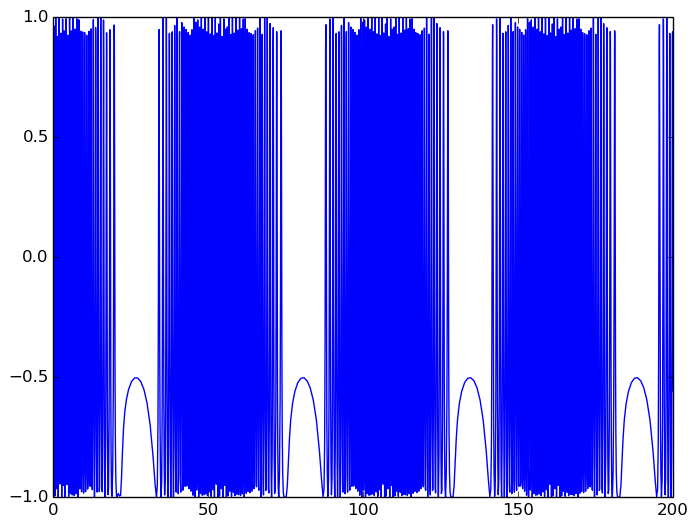

In [49]:
plot(Tres,cosX)
xlim([0.0,200.0])
show()

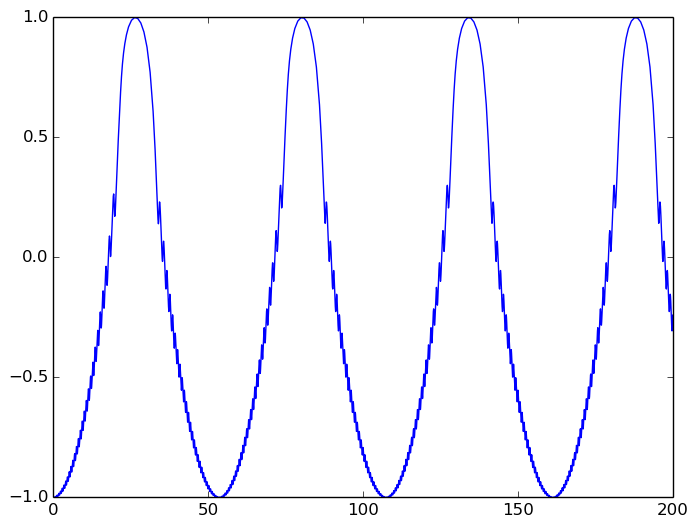

In [50]:
plot(Tres,cosY)
xlim([0.0,200.0])
show()

Ahora resolveremos la siguiente ecuación diferencial que describe el comportamiento de la respiración cuando corremos:


$$\frac{dr}{dt}=-\frac{1}{m}rcos^2(\phi)+sin(\phi)F\frac{1}{\sqrt{km}}$$

$$\frac{d\phi}{dt}=-\omega+cos(\phi) \frac{F}{r\sqrt{km}}-sin(\phi)cos(\phi)\frac{1}{m} $$


Tomaremos $m=20,A=\frac{F}{\sqrt{km}}=1, \ \omega_0=\frac{1}{2}(1+tanh(1)), \ \omega_{MR}=tanh(1)(1-tanh(1))\frac{2}{\omega_0}$

In [51]:

    ω_0=.5*(tanh(1)+1)#Condiciones iniciales
    ω_MR=tanh(1)*(1-tanh(1))*2/ω_0

0.41228224323048973

In [52]:
# Función respiración etermina los coeficientes de la series de Taylor según las ecuaciones (A) y (B).
function respiracion{T<:Real}(vec::Array{T,1} , N::Int) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor y σ
    xT = Taylor1(vec[1], N)# Los primeros términos de la serie x0 y y0 
    yT = Taylor1(vec[2], N)
    
   
   # ω_0=.5*(tanh(1)+1)#Condiciones iniciales
    #ω_MR=tanh(1)*(1-tanh(1))*2/ω_0
    m=20
    
    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xTt = Taylor1( xT.coeffs[1:k+1], k)
        yTt = Taylor1( yT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas por (A) y (B)
        Dx = (-1/m)*xTt*cos(yTt)*cos(yTt)+sin(yTt)
        Dy = -ω_MR+cos(yTt)/xTt-(1/m)*cos(yTt)*sin(yTt)
        # Los términos k+1 están determinados por (1)
        xT.coeffs[knext+1]  = Dx.coeffs[knext] / knext
        yT.coeffs[knext+1]  = Dy.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xT, yT]
end

respiracion (generic function with 1 method)

In [53]:
t,x,y=Integrador1(-π,-π,200.0,respiracion,10.0^(-10),20);

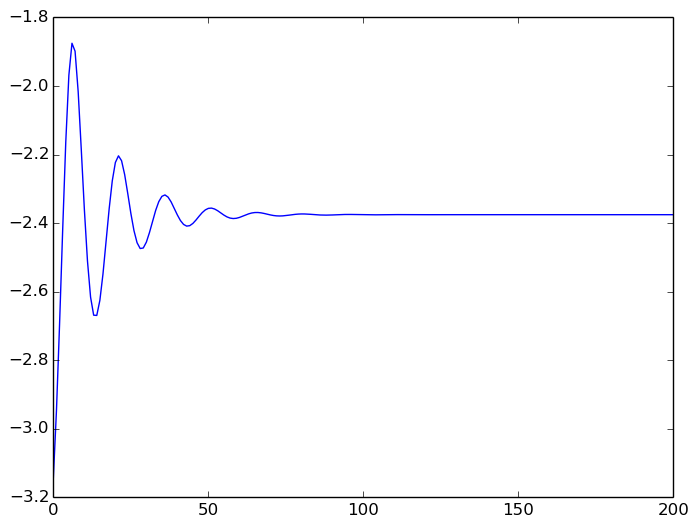

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7cf4a9a490>

In [54]:
plot(t,x)

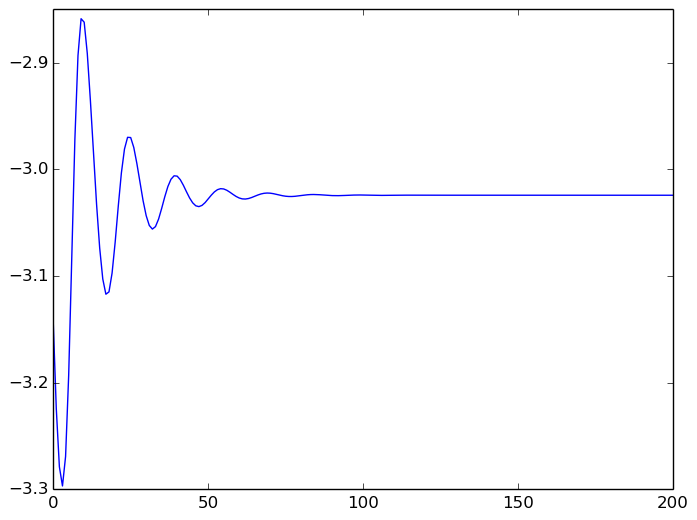

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7cf4848210>

In [55]:
plot(t,y)